<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/PowerGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Power Plant dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/power.ipynb" # Run the Power notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Set the seed for NumPy's random number generator
np.random.seed(0)

torch.manual_seed(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

# Prepare The Data

In [4]:
powerPlant_data = df_PowerPlant # df_PowerPlant is defined in ../datasets/power.ipynb
# The last column is output(net hourly electrical energy output (EP)  of the plant)
x_power, y_power = powerPlant_data.iloc[:, :-1].to_numpy() , powerPlant_data.iloc[:, -1].to_numpy()


x_train_power, x_test_power, y_train_power, y_test_power = train_test_split(x_power, y_power, test_size=0.2, random_state=666)
# Transform into tensors
x_train_power, x_test_power, y_train_power, y_test_power = (
torch.from_numpy(x_train_power).float(), torch.from_numpy(x_test_power).float(),
torch.from_numpy(y_train_power).float(), torch.from_numpy(y_test_power).float())

# Standardized data
scaler = StandardScaler()
x_train_power_standardized = torch.from_numpy(scaler.fit_transform(x_train_power)).float()
# Use the same scaler that was used on training data
x_test_power_standardized = torch.from_numpy(scaler.transform(x_test_power)).float()

if torch.cuda.is_available():
    x_train_power, y_train_power, x_test_power, y_test_power, x_train_power_standardized, x_test_power_standardized = (
    x_train_power.cuda(), y_train_power.cuda(), x_test_power.cuda(), y_test_power.cuda(),
    x_train_power_standardized.cuda(), x_test_power_standardized.cuda())

# Train data into batches
#train_dataset_power = TensorDataset(x_train_power, y_train_power)
#train_loader_power = DataLoader(train_dataset_power, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_power = TensorDataset(x_test_power, y_test_power)
#test_loader_power = DataLoader(test_dataset_power, batch_size=500, shuffle=False)

# Standardized batches
# Train data into batches
#train_dataset_power_standardized = TensorDataset(x_train_power_standardized, y_train_power)
#train_loader_power_standardized = DataLoader(train_dataset_power_standardized, batch_size=500, shuffle=True)

# Test data into batches
#test_dataset_power_standardized = TensorDataset(x_test_power_standardized, y_test_power)
#test_loader_power_standardized = DataLoader(test_dataset_power_standardized, batch_size=500, shuffle=False)

# Define the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  res = cls(index_tensor, value_tensor, interp_size)


RMSE KISS-GP:  4.306115
NLPD KISS-GP:  3.3589181900024414
PICP KISS-GP:  0.7429467084639498
MPIW KISS-GP:  9.664638
Time KISS-GP:  530.2065207958221
RMSE KISS-GP Standardized:  4.288262
NLPD KISS-GP Standardized:  3.3456928730010986
PICP KISS-GP Standardized:  0.7361546499477534
MPIW KISS-GP Standardized:  9.607788
Time KISS-GP Standardized:  493.8781626224518
RMSE KISS-GP:  4.428363
NLPD KISS-GP:  3.449545383453369
PICP KISS-GP:  0.7335423197492164
MPIW KISS-GP:  9.633531
Time KISS-GP:  515.6753127574921
RMSE KISS-GP Standardized:  5.3126497
NLPD KISS-GP Standardized:  4.386977195739746
PICP KISS-GP Standardized:  0.5721003134796239
MPIW KISS-GP Standardized:  9.094664
Time KISS-GP Standardized:  487.20274209976196


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


RMSE KISS-GP:  4.5285892
NLPD KISS-GP:  3.516969680786133
PICP KISS-GP:  0.7100313479623824
MPIW KISS-GP:  9.672491
Time KISS-GP:  516.5707447528839
RMSE KISS-GP Standardized:  4.4511766
NLPD KISS-GP Standardized:  3.464238166809082
PICP KISS-GP Standardized:  0.7100313479623824
MPIW KISS-GP Standardized:  9.607743
Time KISS-GP Standardized:  493.25447821617126
RMSE KISS-GP:  6.241587
NLPD KISS-GP:  5.047839164733887
PICP KISS-GP:  0.53239289446186
MPIW KISS-GP:  9.635304
Time KISS-GP:  521.7174446582794
RMSE KISS-GP Standardized:  4.466074
NLPD KISS-GP Standardized:  3.476278066635132
PICP KISS-GP Standardized:  0.7048066875653083
MPIW KISS-GP Standardized:  9.603577
Time KISS-GP Standardized:  490.56947445869446


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


RMSE KISS-GP:  4.3024106
NLPD KISS-GP:  3.3652772903442383
PICP KISS-GP:  0.7403343782654127
MPIW KISS-GP:  9.63816
Time KISS-GP:  513.1533789634705
RMSE KISS-GP Standardized:  6.147645
NLPD KISS-GP Standardized:  5.019446849822998
PICP KISS-GP Standardized:  0.5402298850574713
MPIW KISS-GP Standardized:  9.504635
Time KISS-GP Standardized:  471.65282583236694


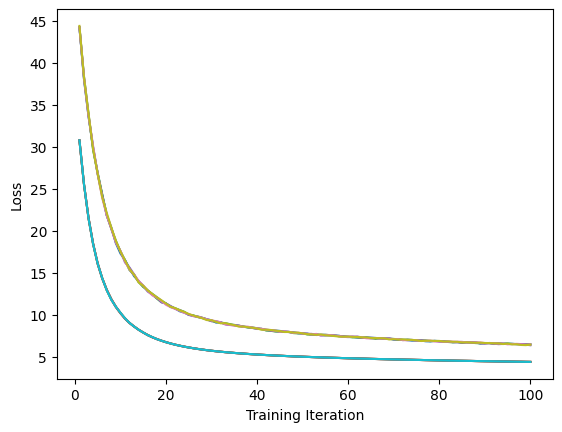

In [5]:
RMSE_list_KISSGP = []
NLPD_list_KISSGP = []
PICP_list_KISSGP = []
MPIW_list_KISSGP = []
TT_list_KISSGP = []

RMSE_list_KISSGP_s = []
NLPD_list_KISSGP_s = []
PICP_list_KISSGP_s = []
MPIW_list_KISSGP_s = []
TT_list_KISSGP_s = []
for _ in range(0,5):
  KISSGP_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  KISSGP_mean_power = gpytorch.means.ConstantMean() # Mean
  KISSGP_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
  KISSGP_model_power = KISSGP_NDim(x_train_power,
                                  y_train_power,
                                  KISSGP_likelihood_power,
                                  KISSGP_mean_power,
                                  KISSGP_kernel_power) # KISSGP defined in utils/Models.ipynb
  KISSGP_model_power = KISSGP_model_power.to(device) # Move model to device.

  # One with standardized features
  KISSGP_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  KISSGP_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
  KISSGP_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
  KISSGP_model_power_standardized = KISSGP_NDim(x_train_power_standardized,
                                                y_train_power,
                                                KISSGP_likelihood_power_standardized,
                                                KISSGP_mean_power_standardized,
                                                KISSGP_kernel_power_standardized) # KISSGP defined in utils/Models.ipynb
  KISSGP_model_power_standardized = KISSGP_model_power_standardized.to(device) # Move model to device.




  train_time_KISSGP_power = train(KISSGP_model_power,
                            KISSGP_likelihood_power,
                            x_train_power,
                            y_train_power,
                            training_iter= 100) # train is defined in utils/functions.ipynb
  # Standardized version
  train_time_KISSGP_power_standardized = train(KISSGP_model_power_standardized,
                                        KISSGP_likelihood_power_standardized,
                                        x_train_power_standardized,
                                        y_train_power,
                                        training_iter= 100) # train is defined in utils/functions.ipynb



  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_KISSGP_power = predict(KISSGP_model_power, KISSGP_likelihood_power,
                                      x_test_power) # predict is defined in utils/functions.ipynb
    RMSE_KISSGP_power, NLPD_KISSGP_power, PICP_KISSGP_power, MPIW_KISSGP_power = error_metrics(
        x_test_power,
        y_test_power,
        predictions_KISSGP_power.mean,
        predictions_KISSGP_power.variance)# error_metrics defined in utils/functions.ipynb


    RMSE_list_KISSGP.append(RMSE_KISSGP_power)
    NLPD_list_KISSGP.append(NLPD_KISSGP_power)
    PICP_list_KISSGP.append(PICP_KISSGP_power)
    MPIW_list_KISSGP.append(MPIW_KISSGP_power)
    TT_list_KISSGP.append(train_time_KISSGP_power)

    # Standardized version
    predictions_KISSGP_power_standardized = predict(KISSGP_model_power_standardized, KISSGP_likelihood_power_standardized,
                                                    x_test_power_standardized) # predict is defined in utils/functions.ipynb

    RMSE_KISSGP_power_standardized, NLPD_KISSGP_power_standardized, PICP_KISSGP_power_standardized, MPIW_KISSGP_power_standardized = error_metrics(
        x_test_power_standardized,
        y_test_power,
        predictions_KISSGP_power_standardized.mean,
        predictions_KISSGP_power_standardized.variance)# error_metrics defined in utils/functions.ipynb

    RMSE_list_KISSGP_s.append(RMSE_KISSGP_power_standardized)
    NLPD_list_KISSGP_s.append(NLPD_KISSGP_power_standardized)
    PICP_list_KISSGP_s.append(PICP_KISSGP_power_standardized)
    MPIW_list_KISSGP_s.append(MPIW_KISSGP_power_standardized)
    TT_list_KISSGP_s.append(train_time_KISSGP_power_standardized)
    print("RMSE KISS-GP: ",RMSE_KISSGP_power)
    print("NLPD KISS-GP: ",NLPD_KISSGP_power)
    print("PICP KISS-GP: ",PICP_KISSGP_power)
    print("MPIW KISS-GP: ",MPIW_KISSGP_power)
    print("Time KISS-GP: ", train_time_KISSGP_power)

    print("RMSE KISS-GP Standardized: ",RMSE_KISSGP_power_standardized)
    print("NLPD KISS-GP Standardized: ",NLPD_KISSGP_power_standardized)
    print("PICP KISS-GP Standardized: ",PICP_KISSGP_power_standardized)
    print("MPIW KISS-GP Standardized: ",MPIW_KISSGP_power_standardized)
    print("Time KISS-GP Standardized: ", train_time_KISSGP_power_standardized)

# Variational Distribution Model

RMSE variational Model:  26.702402
NLPD variational Model:  64.3327407836914
PICP variational Model:  0.19592476489028213
MPIW variational Model:  9.203711
Time variational Model:  138.26736545562744
RMSE variational Model Standardized:  14.139507
NLPD variational Model Standardized:  20.6914005279541
PICP variational Model Standardized:  0.3432601880877743
MPIW variational Model Standardized:  9.041817
Time variational Model Standardized:  111.13212704658508
RMSE variational Model:  26.098324
NLPD variational Model:  61.82243347167969
PICP variational Model:  0.17920585161964472
MPIW variational Model:  9.195398
Time variational Model:  122.59954380989075
RMSE variational Model Standardized:  13.0993805
NLPD variational Model Standardized:  18.743526458740234
PICP variational Model Standardized:  0.24294670846394983
MPIW variational Model Standardized:  8.749175
Time variational Model Standardized:  110.5997257232666
RMSE variational Model:  26.104319
NLPD variational Model:  62.45940

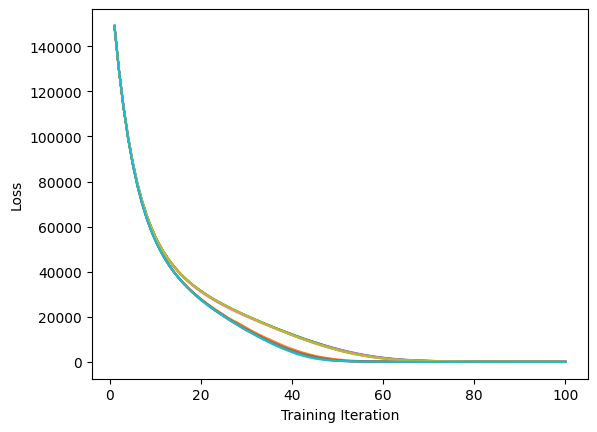

In [6]:
RMSE_list_variational = []
NLPD_list_variational = []
PICP_list_variational = []
MPIW_list_variational = []
TT_list_variational = []

RMSE_list_variational_s = []
NLPD_list_variational_s = []
PICP_list_variational_s = []
MPIW_list_variational_s = []
TT_list_variational_s = []
for _ in range(0,5):
  variational_likelihood_power = gpytorch.likelihoods.GaussianLikelihood()
  variational_mean_power = gpytorch.means.ConstantMean()
  variational_kernel_power = gpytorch.kernels.RBFKernel()
  n_inducing_points = int(len(x_train_power)/10)
  # Generate a tensor of random indices
  indices = torch.randperm(x_train_power.size(0))
  # Select N random rows
  inducing_points = x_train_power[indices][:n_inducing_points]
  variational_model_power = variationalGP(variational_likelihood_power,
                                          variational_mean_power,
                                          variational_kernel_power,
                                          inducing_points) # InducingGP defined in utils/models.ipynb
  variational_model_power = variational_model_power.to(device) # Move model to device, defined in utils/models.ipynb

  # Standardized version
  variational_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood()
  variational_mean_power_standardized = gpytorch.means.ConstantMean()
  variational_kernel_power_standardized = gpytorch.kernels.RBFKernel()
  n_inducing_points = int(len(x_train_power)/10)
  # Generate a tensor of random indices
  indices = torch.randperm(x_train_power_standardized.size(0))
  # Select N random rows
  inducing_points_standardized = x_train_power_standardized[indices][:n_inducing_points]
  variational_model_power_standardized = variationalGP(variational_likelihood_power_standardized,
                                                variational_mean_power_standardized,
                                                variational_kernel_power_standardized,
                                                inducing_points_standardized) # InducingGP defined in utils/models.ipynb
  variational_model_power_standardized = variational_model_power_standardized.to(device) # Move model to device, defined in utils/models.ipynb





  train_time_variational_power = train_ELBO(variational_model_power,
                                  variational_likelihood_power,
                                  x_train_power,
                                  y_train_power,
                                  training_iter= 100) # train is defined in utils/functions.ipynb


  # Standardized version
  train_time_variational_power_standardized = train_ELBO(variational_model_power_standardized,
                                                variational_likelihood_power_standardized,
                                                x_train_power_standardized,
                                                y_train_power,
                                                training_iter= 100) # train is defined in utils/functions.ipynb



  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # predict is defined in utils/functions.ipynb
    predictions_variational_power = predict(variational_model_power, variational_likelihood_power, x_test_power)

    RMSE_variational_power, NLPD_variational_power, PICP_variational_power, MPIW_variational_power = error_metrics(
        x_test_power,
        y_test_power,
        predictions_variational_power.mean,
        predictions_variational_power.variance)# error_metrics defined in utils/functions.ipynb
    print("RMSE variational Model: ",RMSE_variational_power)
    print("NLPD variational Model: ",NLPD_variational_power)
    print("PICP variational Model: ",PICP_variational_power)
    print("MPIW variational Model: ",MPIW_variational_power)
    print("Time variational Model: ", train_time_variational_power)


    RMSE_list_variational.append(RMSE_variational_power)
    NLPD_list_variational.append(NLPD_variational_power)
    PICP_list_variational.append(PICP_variational_power)
    MPIW_list_variational.append(MPIW_variational_power)
    TT_list_variational.append(train_time_variational_power)

    # Standardized version
    predictions_variational_power_standardized = predict(variational_model_power_standardized,
                                        variational_likelihood_power_standardized,
                                        x_test_power_standardized)

    RMSE_variational_power_standardized, NLPD_variational_power_standardized, PICP_variational_power_standardized, MPIW_variational_power_standardized = error_metrics(
        x_test_power_standardized,
        y_test_power,
        predictions_variational_power_standardized.mean,
        predictions_variational_power_standardized.variance)# error_metrics defined in utils/functions.ipynb
    print("RMSE variational Model Standardized: ",RMSE_variational_power_standardized)
    print("NLPD variational Model Standardized: ",NLPD_variational_power_standardized)
    print("PICP variational Model Standardized: ",PICP_variational_power_standardized)
    print("MPIW variational Model Standardized: ",MPIW_variational_power_standardized)
    print("Time variational Model Standardized: ", train_time_variational_power_standardized)

    RMSE_list_variational_s.append(RMSE_variational_power_standardized)
    NLPD_list_variational_s.append(NLPD_variational_power_standardized)
    PICP_list_variational_s.append(PICP_variational_power_standardized)
    MPIW_list_variational_s.append(MPIW_variational_power_standardized)
    TT_list_variational_s.append(train_time_variational_power_standardized)

# Inducing Points Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  33.46844
NLPD inducing:  161.7154541015625
PICP inducing:  0.21577847439916406
MPIW inducing:  7.0505905
Time inducing:  735.0646288394928
RMSE inducing Standardized:  7.7042317
NLPD inducing Standardized:  8.08307933807373
PICP inducing Standardized:  0.4843260188087774
MPIW inducing Standardized:  8.431445
Time inducing Standardized:  129.97912192344666


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  34.008842
NLPD inducing:  166.73789978027344
PICP inducing:  0.2220480668756531
MPIW inducing:  7.0364594
Time inducing:  701.7805097103119
RMSE inducing Standardized:  7.43187
NLPD inducing Standardized:  8.110527992248535
PICP inducing Standardized:  0.4843260188087774
MPIW inducing Standardized:  8.0901785
Time inducing Standardized:  133.30684685707092


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  34.30221
NLPD inducing:  170.15362548828125
PICP inducing:  0.21630094043887146
MPIW inducing:  7.017577
Time inducing:  727.9583184719086
RMSE inducing Standardized:  7.715669
NLPD inducing Standardized:  8.03799819946289
PICP inducing Standardized:  0.4827586206896552
MPIW inducing Standardized:  8.477942
Time inducing Standardized:  137.37654185295105


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  34.141857
NLPD inducing:  168.361328125
PICP inducing:  0.21786833855799373
MPIW inducing:  7.024311
Time inducing:  711.5948405265808
RMSE inducing Standardized:  7.5873594
NLPD inducing Standardized:  8.03098201751709
PICP inducing Standardized:  0.48537095088819227
MPIW inducing Standardized:  8.330134
Time inducing Standardized:  138.92257499694824


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


RMSE inducing:  33.83054
NLPD inducing:  167.1696014404297
PICP inducing:  0.21891327063740856
MPIW inducing:  6.997338
Time inducing:  740.7262644767761
RMSE inducing Standardized:  7.550908
NLPD inducing Standardized:  8.136751174926758
PICP inducing Standardized:  0.4864158829676071
MPIW inducing Standardized:  8.212331
Time inducing Standardized:  136.0449492931366


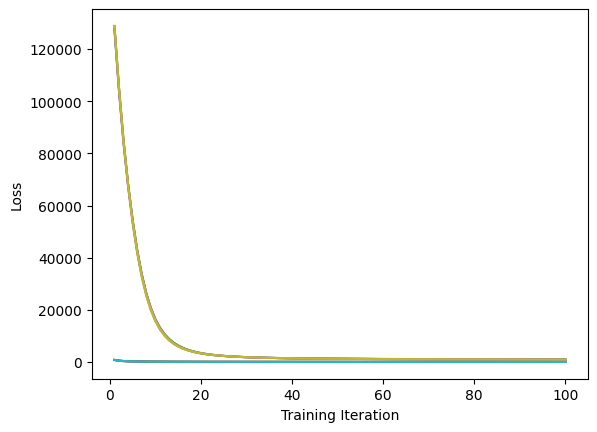

In [7]:
RMSE_list_inducing = []
NLPD_list_inducing = []
PICP_list_inducing = []
MPIW_list_inducing = []
TT_list_inducing = []

RMSE_list_inducing_s = []
NLPD_list_inducing_s = []
PICP_list_inducing_s = []
MPIW_list_inducing_s = []
TT_list_inducing_s = []
for _ in range(0,5):
  inducing_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  inducing_mean_power = gpytorch.means.ConstantMean() # Mean
  inducing_kernel_power = gpytorch.kernels.RBFKernel() # Kernel
  # Choose random inital inducing points
  # Generate a tensor of random indices
  indices = torch.randperm(x_train_power.size(0))
  # Select N random rows
  inducing_points_amount = int(len(x_train_power)/10)
  inducing_points = x_train_power[indices][:inducing_points_amount]
  inducing_model_power = inducingGP(x_train_power,
                                  y_train_power,
                                  inducing_likelihood_power,
                                  inducing_mean_power,
                                  inducing_kernel_power,
                                  inducing_points) # inducingGP defined in utils/Models.ipynb

  inducing_model_power = inducing_model_power.to(device) # Move model to device.

  # One with standardized features
  inducing_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  inducing_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
  inducing_kernel_power_standardized = gpytorch.kernels.RBFKernel() # Kernel
  # Generate a tensor of random indices
  indices = torch.randperm(x_train_power_standardized.size(0))
  # Select N random rows
  inducing_points_standardized = x_train_power_standardized[indices][:inducing_points_amount]
  inducing_model_power_standardized = inducingGP(x_train_power_standardized,
                                                y_train_power,
                                                inducing_likelihood_power_standardized,
                                                inducing_mean_power_standardized,
                                                inducing_kernel_power_standardized,
                                                inducing_points_standardized) # inducingGP defined in utils/Models.ipynb

  inducing_model_power_standardized = inducing_model_power_standardized.to(device) # Move model to device.




  train_time_inducing_power = train(inducing_model_power,
                            inducing_likelihood_power,
                            x_train_power,
                            y_train_power,
                            training_iter= 100) # train is defined in utils/functions.ipynb
  # Standardized version
  train_time_inducing_power_standardized = train(inducing_model_power_standardized,
                                        inducing_likelihood_power_standardized,
                                        x_train_power_standardized,
                                        y_train_power,
                                        training_iter= 100) # train is defined in utils/functions.ipynb





  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_inducing_power = predict(inducing_model_power, inducing_likelihood_power,
                                      x_test_power) # predict is defined in utils/functions.ipynb
    RMSE_inducing_power, NLPD_inducing_power, PICP_inducing_power, MPIW_inducing_power = error_metrics(
        x_test_power,
        y_test_power,
        predictions_inducing_power.mean,
        predictions_inducing_power.variance)# error_metrics defined in utils/functions.ipynb


    RMSE_list_inducing.append(RMSE_inducing_power)
    NLPD_list_inducing.append(NLPD_inducing_power)
    PICP_list_inducing.append(PICP_inducing_power)
    MPIW_list_inducing.append(MPIW_inducing_power)
    TT_list_inducing.append(train_time_inducing_power)

    # Standardized version
    predictions_inducing_power_standardized = predict(inducing_model_power_standardized, inducing_likelihood_power_standardized,
                                                    x_test_power_standardized) # predict is defined in utils/functions.ipynb

    RMSE_inducing_power_standardized, NLPD_inducing_power_standardized, PICP_inducing_power_standardized, MPIW_inducing_power_standardized = error_metrics(
        x_test_power_standardized,
        y_test_power,
        predictions_inducing_power_standardized.mean,
        predictions_inducing_power_standardized.variance)# error_metrics defined in utils/functions.ipynb

    RMSE_list_inducing_s.append(RMSE_inducing_power_standardized)
    NLPD_list_inducing_s.append(NLPD_inducing_power_standardized)
    PICP_list_inducing_s.append(PICP_inducing_power_standardized)
    MPIW_list_inducing_s.append(MPIW_inducing_power_standardized)
    TT_list_inducing_s.append(train_time_inducing_power_standardized)
    print("RMSE inducing: ",RMSE_inducing_power)
    print("NLPD inducing: ",NLPD_inducing_power)
    print("PICP inducing: ",PICP_inducing_power)
    print("MPIW inducing: ",MPIW_inducing_power)
    print("Time inducing: ", train_time_inducing_power)

    print("RMSE inducing Standardized: ",RMSE_inducing_power_standardized)
    print("NLPD inducing Standardized: ",NLPD_inducing_power_standardized)
    print("PICP inducing Standardized: ",PICP_inducing_power_standardized)
    print("MPIW inducing Standardized: ",MPIW_inducing_power_standardized)
    print("Time inducing Standardized: ", train_time_inducing_power_standardized)

# Exact Gaussian Process Model

RMSE Exact-GP:  20.54646
NLPD Exact-GP:  38.55812072753906
PICP Exact-GP:  0.33594566353187044
MPIW Exact-GP:  8.3592
Time Exact-GP:  492.9456715583801
RMSE Exact-GP Standardized:  4.8812213
NLPD Exact-GP Standardized:  4.36433744430542
PICP Exact-GP Standardized:  0.6562173458725182
MPIW Exact-GP Standardized:  8.187682
Time Exact-GP Standardized:  445.28376507759094
RMSE Exact-GP:  20.128853
NLPD Exact-GP:  36.67648696899414
PICP Exact-GP:  0.3991640543364681
MPIW Exact-GP:  8.358257
Time Exact-GP:  508.257746219635
RMSE Exact-GP Standardized:  4.868789
NLPD Exact-GP Standardized:  4.350557327270508
PICP Exact-GP Standardized:  0.6630094043887147
MPIW Exact-GP Standardized:  8.187948
Time Exact-GP Standardized:  453.2565062046051
RMSE Exact-GP:  20.377663
NLPD Exact-GP:  37.70269775390625
PICP Exact-GP:  0.3599791013584117
MPIW Exact-GP:  8.35933
Time Exact-GP:  494.3823068141937
RMSE Exact-GP Standardized:  4.870276
NLPD Exact-GP Standardized:  4.35236120223999
PICP Exact-GP Standar

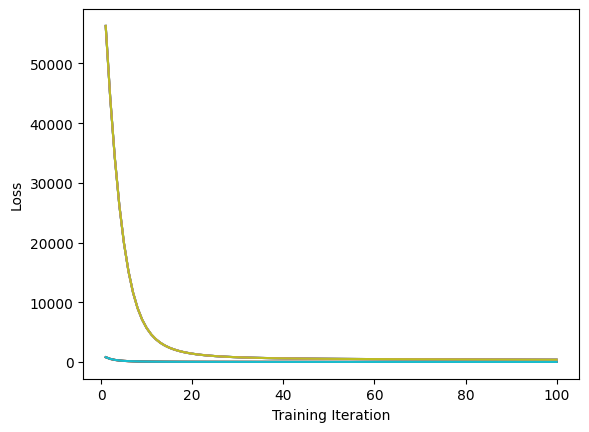

In [8]:
RMSE_list_exact = []
NLPD_list_exact  = []
PICP_list_exact  = []
MPIW_list_exact  = []
TT_list_exact  = []

RMSE_list_exact_s = []
NLPD_list_exact_s = []
PICP_list_exact_s = []
MPIW_list_exact_s = []
TT_list_exact_s = []
for _ in range(0,5):
  exact_likelihood_power = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  exact_mean_power = gpytorch.means.ConstantMean() # Mean
  exact_kernel_power = gpytorch.kernels.MaternKernel() # Kernel
  exact_model_power = exactGP(x_train_power,
                              y_train_power,
                              exact_likelihood_power,
                              exact_mean_power,
                              exact_kernel_power) # exactGP defined in utils/Models.ipynb
  exact_model_power = exact_model_power.to(device) # Move model to device, defined in utils/models.ipynb


  # Standardized version

  exact_likelihood_power_standardized = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
  exact_mean_power_standardized = gpytorch.means.ConstantMean() # Mean
  exact_kernel_power_standardized = gpytorch.kernels.MaternKernel() # Kernel
  exact_model_power_standardized = exactGP(x_train_power_standardized,
                              y_train_power,
                              exact_likelihood_power_standardized,
                              exact_mean_power_standardized,
                              exact_kernel_power_standardized) # exactGP defined in utils/Models.ipynb
  exact_model_power_standardized = exact_model_power_standardized.to(device) # Move model to device, defined in utils/models.ipynb



  train_time_exact_power = train(exact_model_power,
                                  exact_likelihood_power,
                                  x_train_power,
                                  y_train_power,
                                  training_iter= 100) # train is defined in utils/functions.ipynb



  train_time_exact_power_standardized = train(exact_model_power_standardized,
                                  exact_likelihood_power_standardized,
                                  x_train_power_standardized,
                                  y_train_power,
                                  training_iter= 100) # train is defined in utils/functions.ipynb



  # Evaluate
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_exact_power = predict(exact_model_power, exact_likelihood_power,
                                      x_test_power) # predict is defined in utils/functions.ipynb
    RMSE_exact_power, NLPD_exact_power, PICP_exact_power, MPIW_exact_power = error_metrics(
        x_test_power,
        y_test_power,
        predictions_exact_power.mean,
        predictions_exact_power.variance)# error_metrics defined in utils/functions.ipynb


    RMSE_list_exact.append(RMSE_exact_power)
    NLPD_list_exact.append(NLPD_exact_power)
    PICP_list_exact.append(PICP_exact_power)
    MPIW_list_exact.append(MPIW_exact_power)
    TT_list_exact.append(train_time_exact_power)

  # Standardized
  # Evaluate
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_exact_power_standardized = predict(exact_model_power_standardized, exact_likelihood_power_standardized,
                                      x_test_power_standardized) # predict is defined in utils/functions.ipynb
    RMSE_exact_power_standardized, NLPD_exact_power_standardized, PICP_exact_power_standardized, MPIW_exact_power_standardized = error_metrics(
        x_test_power_standardized,
        y_test_power,
        predictions_exact_power_standardized.mean,
        predictions_exact_power_standardized.variance)# error_metrics defined in utils/functions.ipynb

    RMSE_list_exact_s.append(RMSE_exact_power_standardized)
    NLPD_list_exact_s.append(NLPD_exact_power_standardized)
    PICP_list_exact_s.append(PICP_exact_power_standardized)
    MPIW_list_exact_s.append(MPIW_exact_power_standardized)
    TT_list_exact_s.append(train_time_exact_power_standardized)
    print("RMSE Exact-GP: ",RMSE_exact_power)
    print("NLPD Exact-GP: ",NLPD_exact_power)
    print("PICP Exact-GP: ",PICP_exact_power)
    print("MPIW Exact-GP: ",MPIW_exact_power)
    print("Time Exact-GP: ", train_time_exact_power)


    print("RMSE Exact-GP Standardized: ",RMSE_exact_power_standardized)
    print("NLPD Exact-GP Standardized: ",NLPD_exact_power_standardized)
    print("PICP Exact-GP Standardized: ",PICP_exact_power_standardized)
    print("MPIW Exact-GP Standardized: ",MPIW_exact_power_standardized)
    print("Time Exact-GP Standardized: ", train_time_exact_power_standardized)

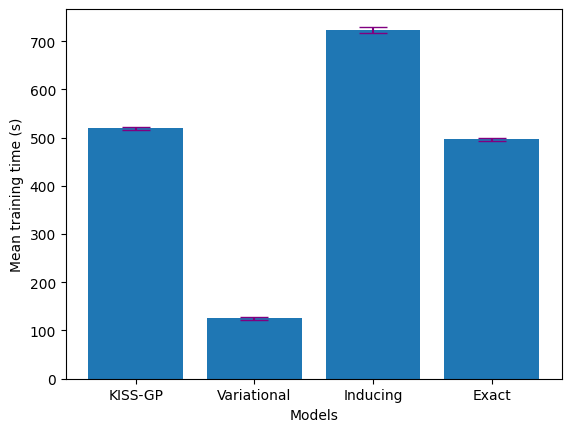

In [9]:
# Calculate standard errors training time
standard_errors_tt = [np.std(x) / np.sqrt(len(x)) for x in
                   [TT_list_KISSGP, TT_list_variational, TT_list_inducing, TT_list_exact]]

# Calculate means
means_tt = [np.mean(x) for x in
         [TT_list_KISSGP, TT_list_variational, TT_list_inducing, TT_list_exact]]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Model names
models = ['KISS-GP', 'Variational', 'Inducing', 'Exact']

# Plot error bars
ax.bar(models, means_tt, yerr=standard_errors_tt, align='center', ecolor='purple', capsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Mean training time (s)')
plt.savefig("error_tt_power.pdf")

Text(0, 0.5, 'Mean RMSE')

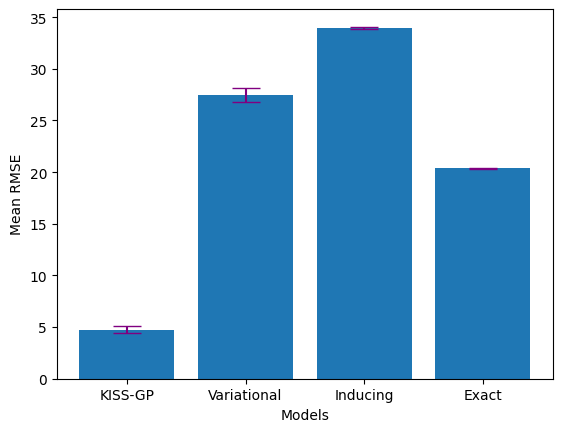

In [10]:
# Calculate standard errors
standard_errors_rmse = [np.std(rmse_values) / np.sqrt(len(rmse_values)) for rmse_values in
                   [RMSE_list_KISSGP, RMSE_list_variational, RMSE_list_inducing, RMSE_list_exact]]

# Calculate means
means_rmse = [np.mean(rmse_values) for rmse_values in
         [RMSE_list_KISSGP, RMSE_list_variational, RMSE_list_inducing, RMSE_list_exact]]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Model names
models = ['KISS-GP', 'Variational', 'Inducing', 'Exact']

# Plot error bars
ax.bar(models, means_rmse, yerr=standard_errors_rmse, align='center', ecolor='purple', capsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Mean RMSE')

Text(0, 0.5, 'Mean NLPD')

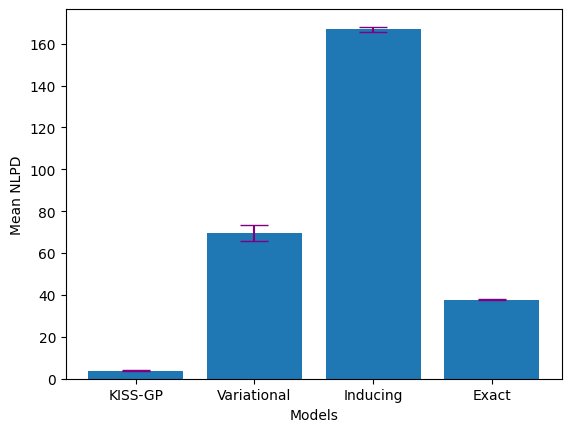

In [11]:
# Calculate standard errors
standard_errors_nlpd = [np.std(x) / np.sqrt(len(x)) for x in
                   [NLPD_list_KISSGP, NLPD_list_variational, NLPD_list_inducing, NLPD_list_exact]]

# Calculate means
means_nlpd = [np.mean(x) for x in
         [NLPD_list_KISSGP, NLPD_list_variational, NLPD_list_inducing, NLPD_list_exact]]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Model names
models = ['KISS-GP', 'Variational', 'Inducing', 'Exact']

# Plot error bars
ax.bar(models, means_nlpd, yerr=standard_errors_nlpd, align='center', ecolor='purple', capsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Mean NLPD')

Text(0, 0.5, 'Mean PICP')

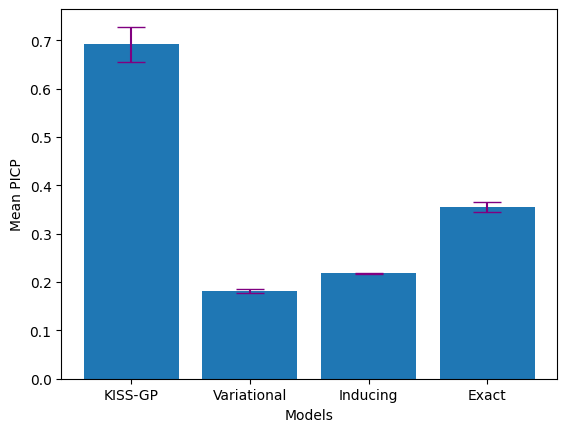

In [12]:
# Calculate standard errors
standard_errors_picp = [np.std(x) / np.sqrt(len(x)) for x in
                   [PICP_list_KISSGP, PICP_list_variational,  PICP_list_inducing, PICP_list_exact]]

# Calculate means
means_picp = [np.mean(x) for x in
         [PICP_list_KISSGP, PICP_list_variational, PICP_list_inducing, PICP_list_exact]]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Model names
models = ['KISS-GP', 'Variational', 'Inducing', 'Exact']

# Plot error bars
ax.bar(models, means_picp, yerr=standard_errors_picp, align='center', ecolor='purple', capsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Mean PICP')

Text(0, 0.5, 'Mean MPIW')

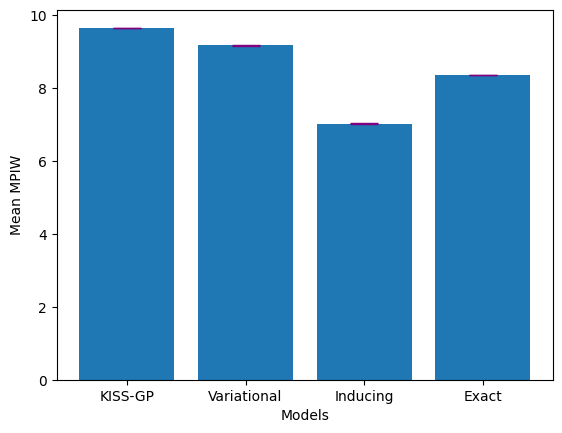

In [13]:
# Calculate standard errors
standard_errors_mpiw = [np.std(x) / np.sqrt(len(x)) for x in
                   [MPIW_list_KISSGP,MPIW_list_variational, MPIW_list_inducing, MPIW_list_exact]]

# Calculate means
means_mpiw = [np.mean(x) for x in
         [MPIW_list_KISSGP, MPIW_list_variational, MPIW_list_inducing, MPIW_list_exact]]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Model names
models = ['KISS-GP', 'Variational', 'Inducing', 'Exact']

# Plot error bars
ax.bar(models, means_mpiw, yerr=standard_errors_mpiw, align='center', ecolor='purple', capsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Mean MPIW')

# Standardized or not

In [14]:
# Calculate standard errors training time
standard_errors_tt_s = [np.std(x) / np.sqrt(len(x)) for x in
                   [TT_list_KISSGP_s, TT_list_variational_s, TT_list_inducing_s, TT_list_exact_s]]

# Calculate means
means_tt_s = [np.mean(x) for x in
         [TT_list_KISSGP_s, TT_list_variational_s, TT_list_inducing_s, TT_list_exact_s]]



# Calculate standard errors
standard_errors_rmse_s = [np.std(rmse_values) / np.sqrt(len(rmse_values)) for rmse_values in
                   [RMSE_list_KISSGP_s, RMSE_list_variational_s, RMSE_list_inducing_s, RMSE_list_exact_s]]

# Calculate means
means_rmse_s = [np.mean(rmse_values) for rmse_values in
         [RMSE_list_KISSGP_s, RMSE_list_variational_s, RMSE_list_inducing_s, RMSE_list_exact_s]]



# Calculate standard errors
standard_errors_nlpd_s = [np.std(x) / np.sqrt(len(x)) for x in
                   [NLPD_list_KISSGP_s, NLPD_list_variational_s, NLPD_list_inducing_s, NLPD_list_exact_s]]

# Calculate means
means_nlpd_s = [np.mean(x) for x in
         [NLPD_list_KISSGP_s, NLPD_list_variational_s, NLPD_list_inducing_s, NLPD_list_exact_s]]



# Calculate standard errors
standard_errors_picp_s = [np.std(x) / np.sqrt(len(x)) for x in
                   [PICP_list_KISSGP_s, PICP_list_variational_s,  PICP_list_inducing_s, PICP_list_exact_s]]

# Calculate means
means_picp_s = [np.mean(x) for x in
         [PICP_list_KISSGP_s, PICP_list_variational_s, PICP_list_inducing_s, PICP_list_exact_s]]




# Calculate standard errors
standard_errors_mpiw_s = [np.std(x) / np.sqrt(len(x)) for x in
                   [MPIW_list_KISSGP_s,MPIW_list_variational_s, MPIW_list_inducing_s, MPIW_list_exact_s]]

# Calculate means
means_mpiw_s = [np.mean(x) for x in
         [MPIW_list_KISSGP_s, MPIW_list_variational_s, MPIW_list_inducing_s, MPIW_list_exact_s]]



tt_compare = []
rmse_compare = []
nlpd_compare = []
picp_compare = []
mpiw_compare = []

for tt, tt_s in zip(means_tt, means_tt_s):
  tt_compare.append(tt)
  tt_compare.append(tt_s)



for rmse, rmse_s in zip(means_rmse, means_rmse_s):
  rmse_compare.append(rmse)
  rmse_compare.append(rmse_s)



for nlpd, nlpd_s in zip(means_nlpd, means_nlpd_s):
  nlpd_compare.append(nlpd)
  nlpd_compare.append(nlpd_s)



for picp, picp_s in zip(means_picp, means_picp_s):
  picp_compare.append(picp)
  picp_compare.append(picp_s)



for mpiw, mpiw_s in zip(means_mpiw, means_mpiw_s):
  mpiw_compare.append(mpiw)
  mpiw_compare.append(mpiw_s)




# ----

tt_compare_error = []
rmse_compare_error = []
nlpd_compare_error = []
picp_compare_error = []
mpiw_compare_error = []

for tt, tt_s in zip(standard_errors_tt, standard_errors_tt_s):
  tt_compare_error.append(tt)
  tt_compare_error.append(tt_s)



for rmse, rmse_s in zip(standard_errors_rmse, standard_errors_rmse_s):
  rmse_compare_error.append(rmse)
  rmse_compare_error.append(rmse_s)



for nlpd, nlpd_s in zip(standard_errors_nlpd, standard_errors_nlpd_s):
  nlpd_compare_error.append(nlpd)
  nlpd_compare_error.append(nlpd_s)



for picp, picp_s in zip(standard_errors_picp, standard_errors_picp_s):
  picp_compare_error.append(picp)
  picp_compare_error.append(picp_s)



for mpiw, mpiw_s in zip(standard_errors_mpiw, standard_errors_mpiw_s):
  mpiw_compare_error.append(mpiw)
  mpiw_compare_error.append(mpiw_s)



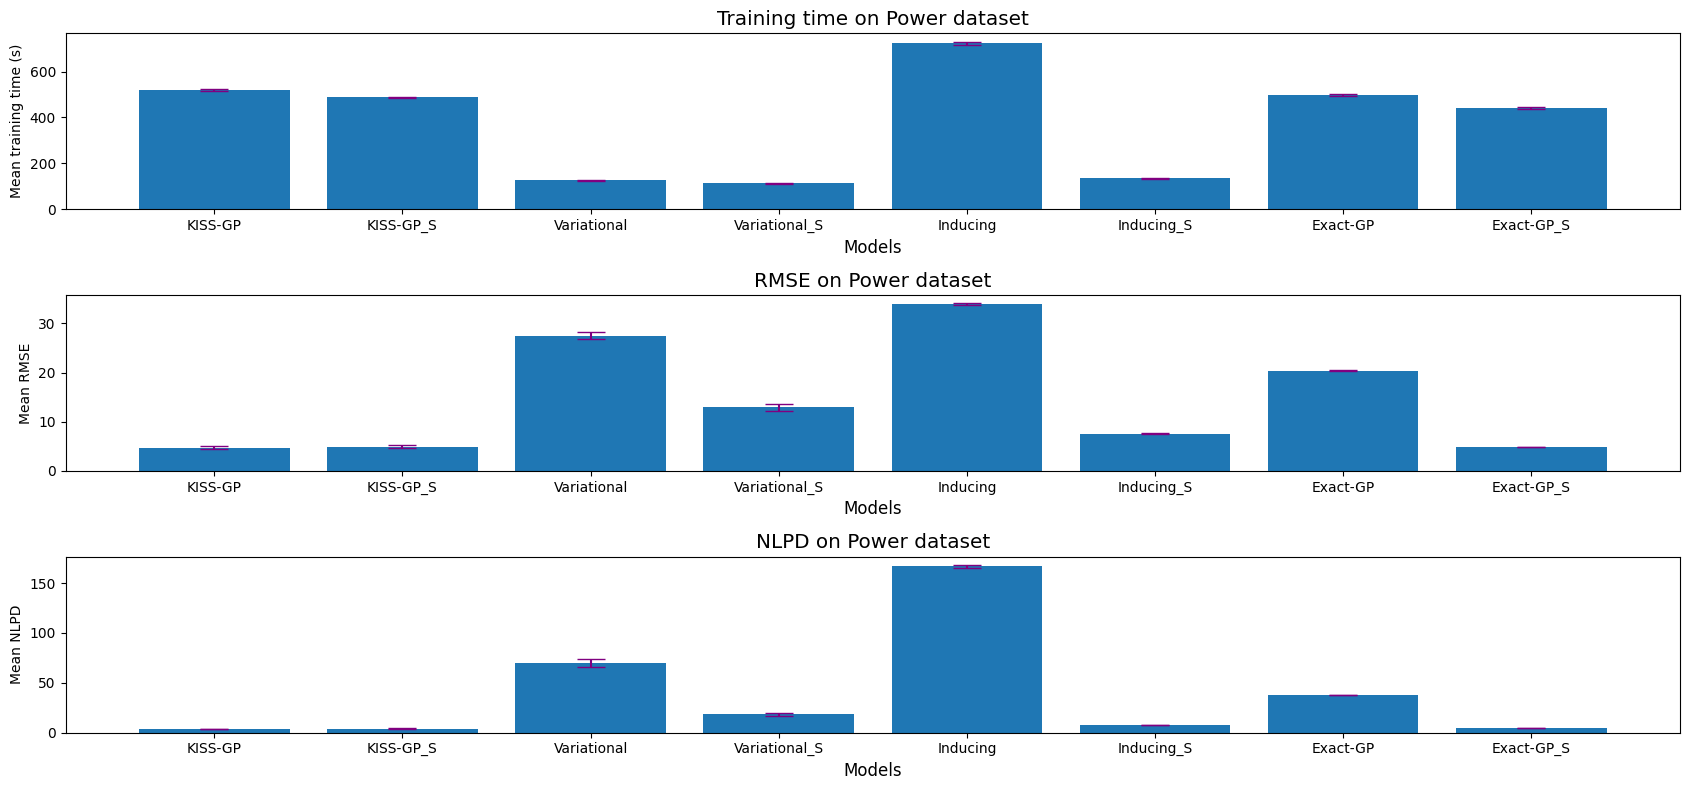

In [15]:
# standardized or not
from matplotlib.gridspec import GridSpec

gs = GridSpec(3, 1)  # 3 rows, 1 columns

fig = plt.figure(figsize=(17, 8))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])



models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]

axes = [ax1, ax2, ax3]  # List of axes
data = [tt_compare, rmse_compare, nlpd_compare]
standard_errors1 = [tt_compare_error, rmse_compare_error, nlpd_compare_error]
titles = ["Training time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], yerr=standard_errors1[i], ecolor='purple', capsize=10)

    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")

ax1.set_ylabel("Mean training time (s)")
ax2.set_ylabel("Mean RMSE")
ax3.set_ylabel("Mean NLPD")
plt.tight_layout()
plt.savefig("metrics_power_compare1.pdf")
plt.show()


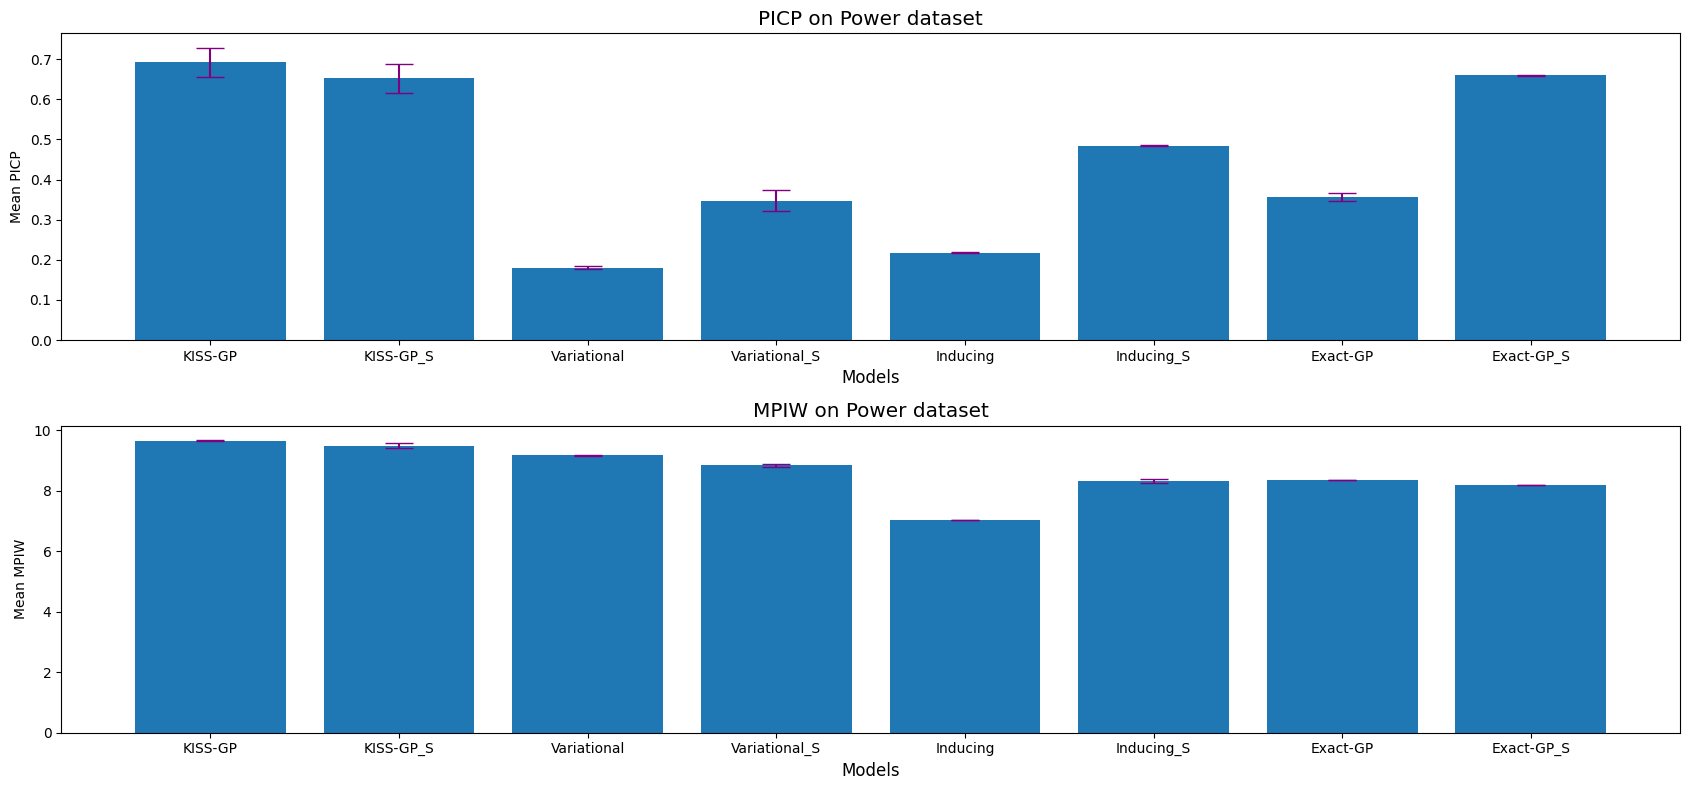

In [16]:
# standardized or not
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 1)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 8))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])




models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]

axes = [ax1, ax2]  # List of axes
data = [picp_compare, mpiw_compare]
standard_errors1 = [picp_compare_error, mpiw_compare_error]
titles = ["PICP on Power dataset", "MPIW on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], yerr=standard_errors1[i], ecolor='purple', capsize=10)

    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")

ax1.set_ylabel("Mean PICP")
ax2.set_ylabel("Mean MPIW")
plt.tight_layout()
plt.savefig("metrics_power_compare2.pdf")
plt.show()

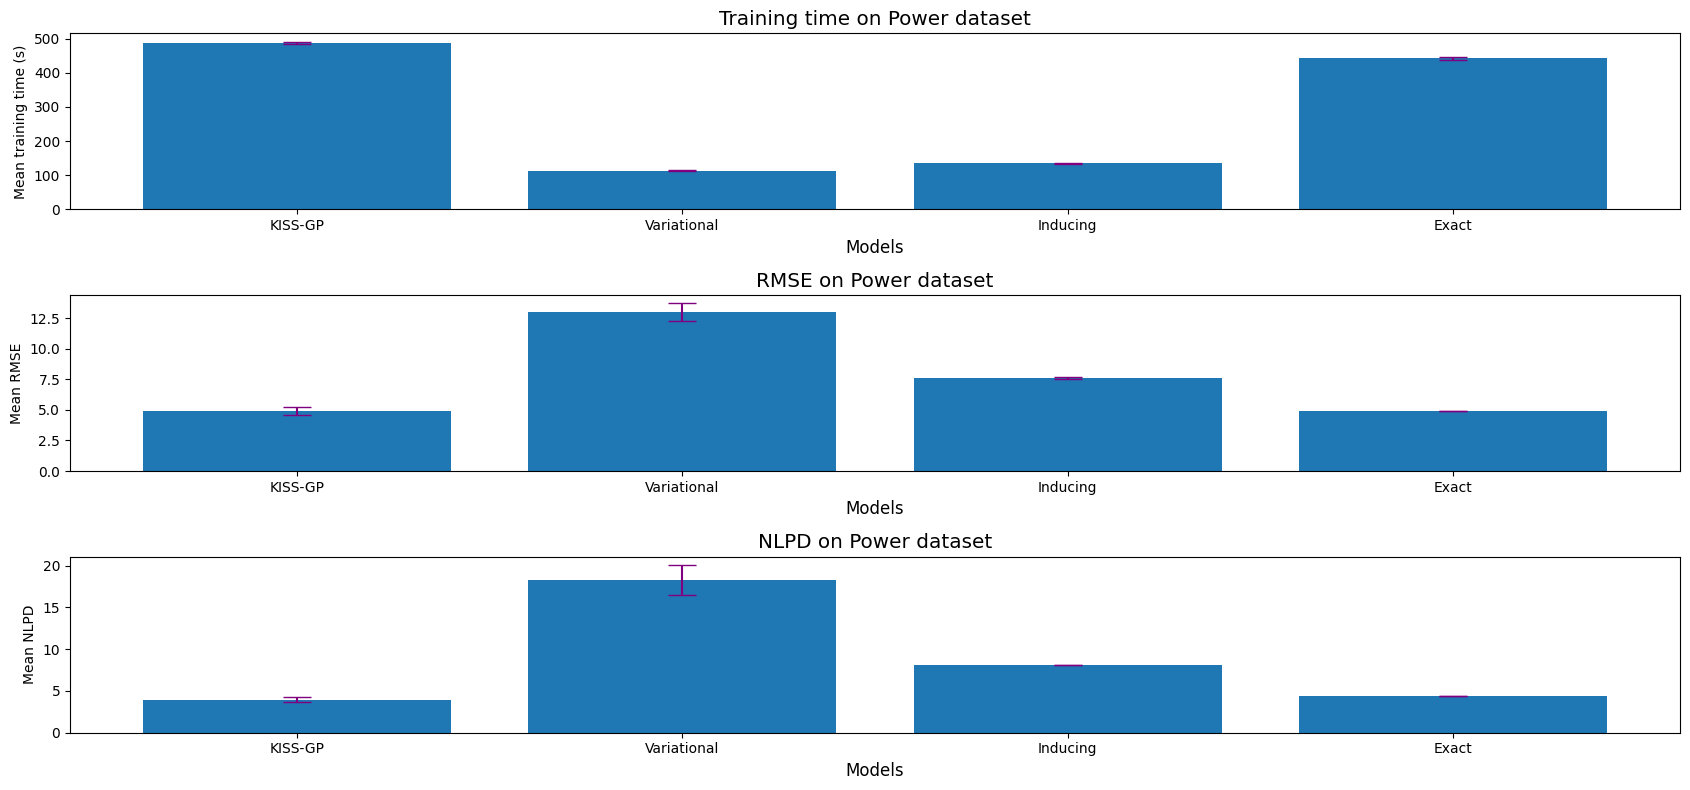

In [17]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(3, 1)  # 3 rows, 1 columns

fig = plt.figure(figsize=(17, 8))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])


axes = [ax1, ax2, ax3]  # List of axes
data = [means_tt_s, means_rmse_s, means_nlpd_s]
standard_errors1 = [standard_errors_tt_s, standard_errors_rmse_s, standard_errors_nlpd_s]
titles = ["Training time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], yerr=standard_errors1[i], ecolor='purple', capsize=10)

    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")

ax1.set_ylabel("Mean training time (s)")
ax2.set_ylabel("Mean RMSE")
ax3.set_ylabel("Mean NLPD")
plt.tight_layout()
plt.savefig("metrics_power1.pdf")
plt.show()

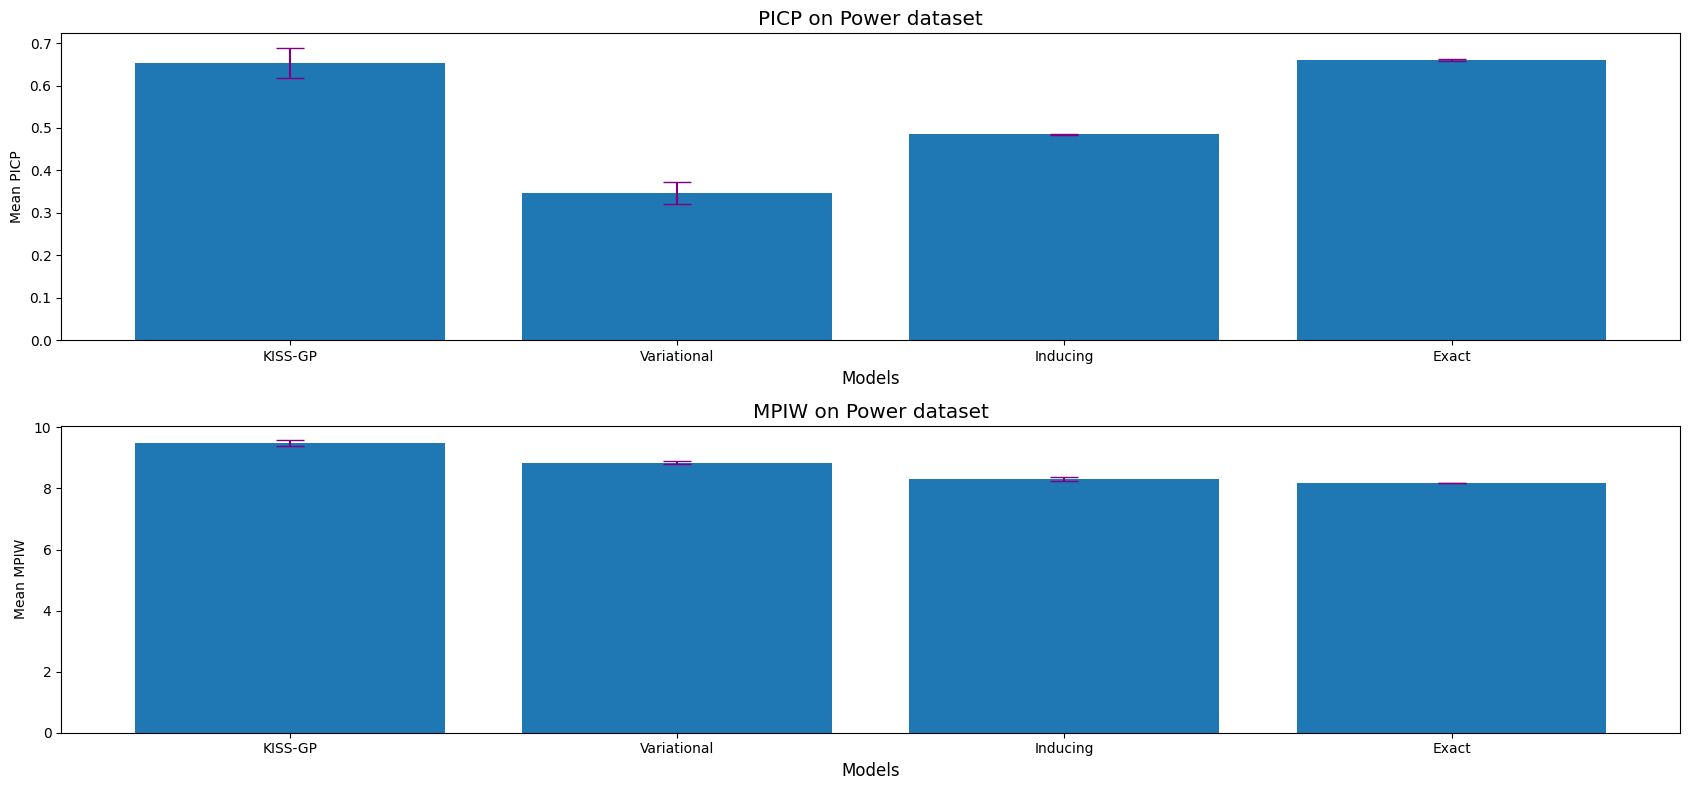

In [18]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 1)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 8))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Spans columns 0-1
ax2 = fig.add_subplot(gs[1, 0])  # Spans columns 2-3


axes = [ax1, ax2]  # List of axes
data = [means_picp_s, means_mpiw_s]
standard_errors2 = [standard_errors_picp_s, standard_errors_mpiw_s]
titles = ["PICP on Power dataset", "MPIW on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], yerr=standard_errors2[i], ecolor='purple', capsize=10)

    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")

ax1.set_ylabel("Mean PICP")
ax2.set_ylabel("Mean MPIW")
plt.tight_layout()
plt.savefig("metrics_power2.pdf")
plt.show()

# Display Results

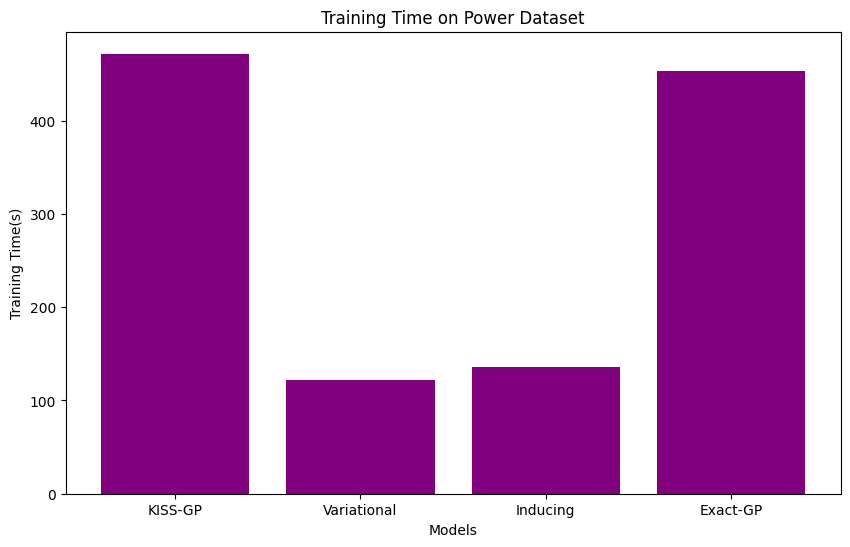

In [19]:
# Training times
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
times_power = [train_time_KISSGP_power_standardized, train_time_variational_power_standardized, train_time_inducing_power_standardized, train_time_exact_power_standardized]
plot_bar(models, times_power, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

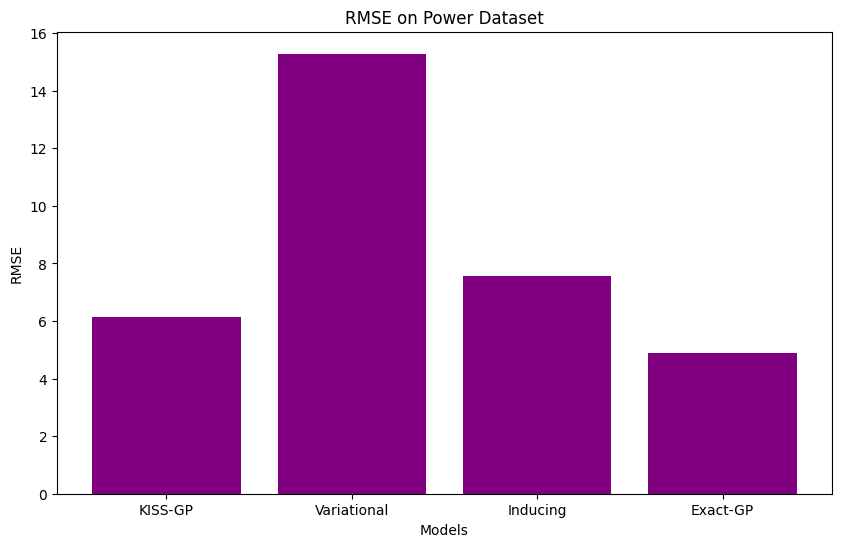

In [20]:
# RMSE
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
RMSE_power = [RMSE_KISSGP_power_standardized, RMSE_variational_power_standardized, RMSE_inducing_power_standardized, RMSE_exact_power_standardized]
plot_bar(models, RMSE_power, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

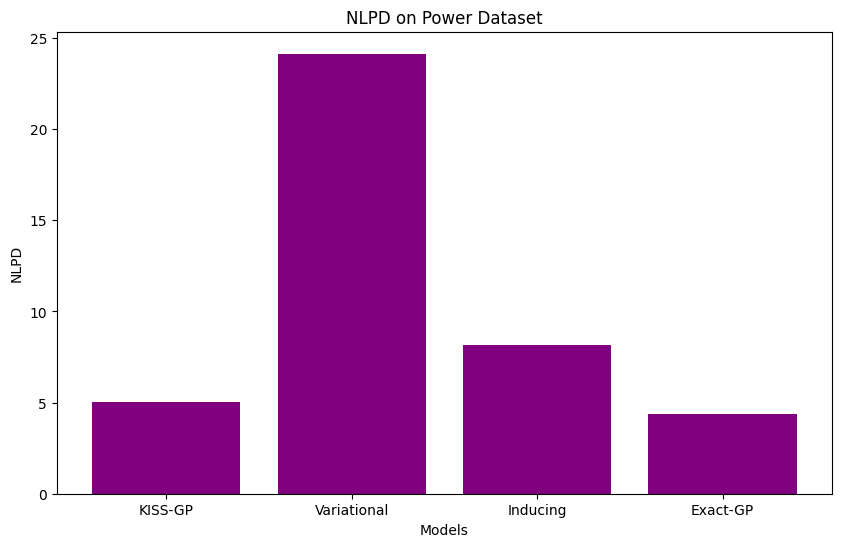

In [21]:
# NLPD
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
NLPD_power = [NLPD_KISSGP_power_standardized, NLPD_variational_power_standardized, NLPD_inducing_power_standardized, NLPD_exact_power_standardized]
plot_bar(models, NLPD_power, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

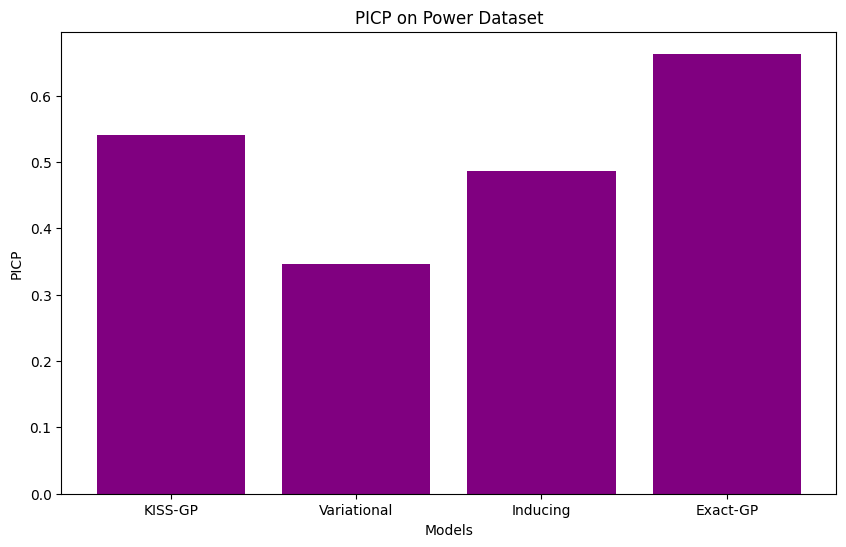

In [22]:
# PICP
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
PICP_power = [PICP_KISSGP_power_standardized, PICP_variational_power_standardized, PICP_inducing_power_standardized, PICP_exact_power_standardized]
plot_bar(models, PICP_power, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

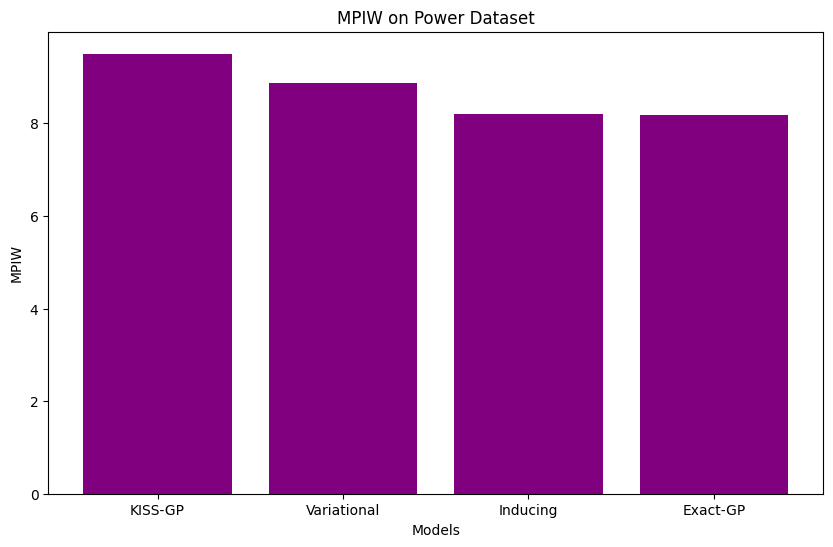

In [23]:
# MPIW
models = ["KISS-GP", "Variational", "Inducing", "Exact-GP"]
MPIW_power = [MPIW_KISSGP_power_standardized, MPIW_variational_power_standardized, MPIW_inducing_power_standardized, MPIW_exact_power_standardized]
plot_bar(models, MPIW_power, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

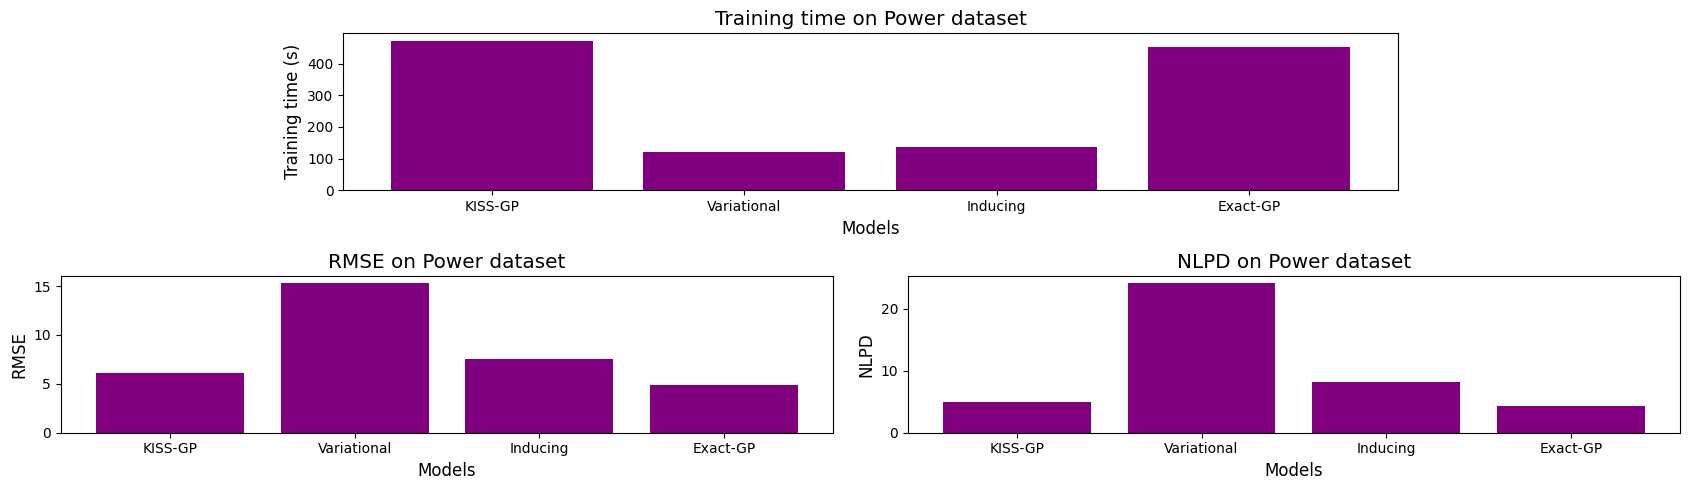

In [24]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])


axes = [ax1, ax2, ax3]  # List of axes
data = [times_power, RMSE_power, NLPD_power]
titles = ["Training time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

ax1.set_ylabel("Training time (s)")
plt.tight_layout()
#plt.savefig("metrics_power1.pdf")
plt.show()

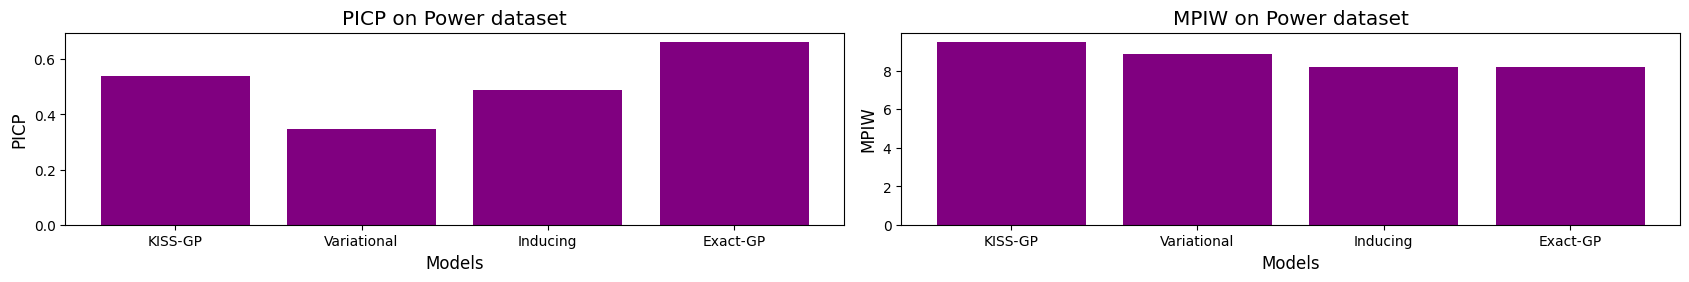

In [25]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])



axes = [ax1, ax2]  # List of axes
data = [PICP_power, MPIW_power]
titles = ["PICP on Power dataset", "MPIW on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
#plt.savefig("metrics_power2.pdf")
plt.show()

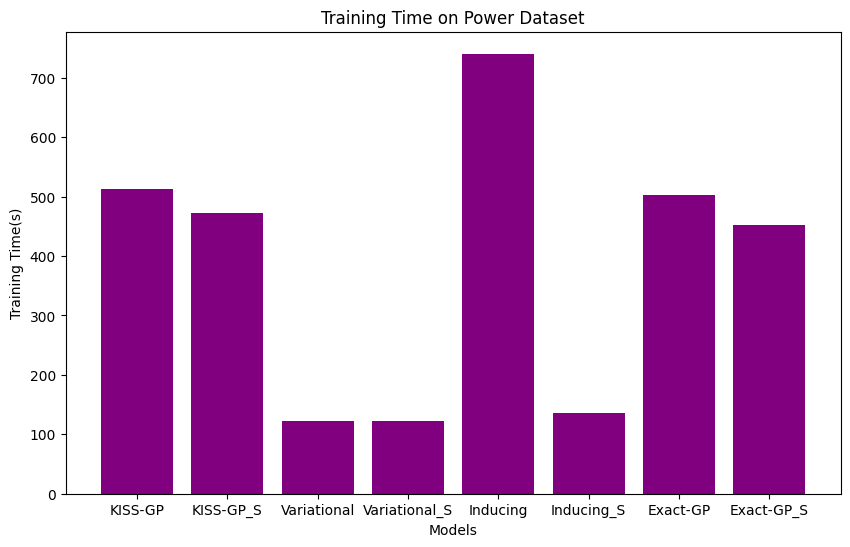

In [26]:
# Standardized or not?
# Training Time
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
time_compare = [train_time_KISSGP_power, train_time_KISSGP_power_standardized,
                train_time_variational_power, train_time_variational_power_standardized,
                train_time_inducing_power, train_time_inducing_power_standardized,
                train_time_exact_power, train_time_exact_power_standardized]
plot_bar(models_compare, time_compare, "Training Time on Power Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

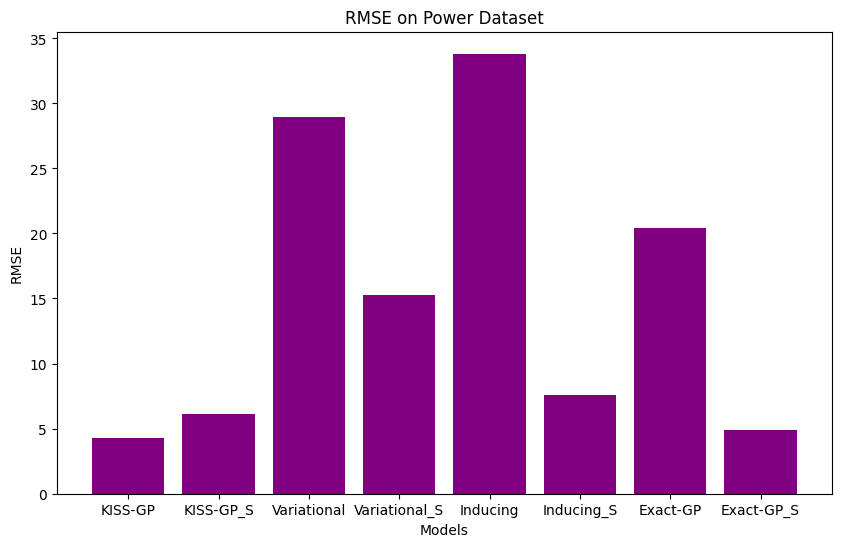

In [27]:
# Standardized or not?
# RMSE
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
RMSE_compare = [RMSE_KISSGP_power, RMSE_KISSGP_power_standardized,
                RMSE_variational_power, RMSE_variational_power_standardized,
                RMSE_inducing_power, RMSE_inducing_power_standardized,
                RMSE_exact_power,RMSE_exact_power_standardized]
plot_bar(models_compare, RMSE_compare, "RMSE on Power Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

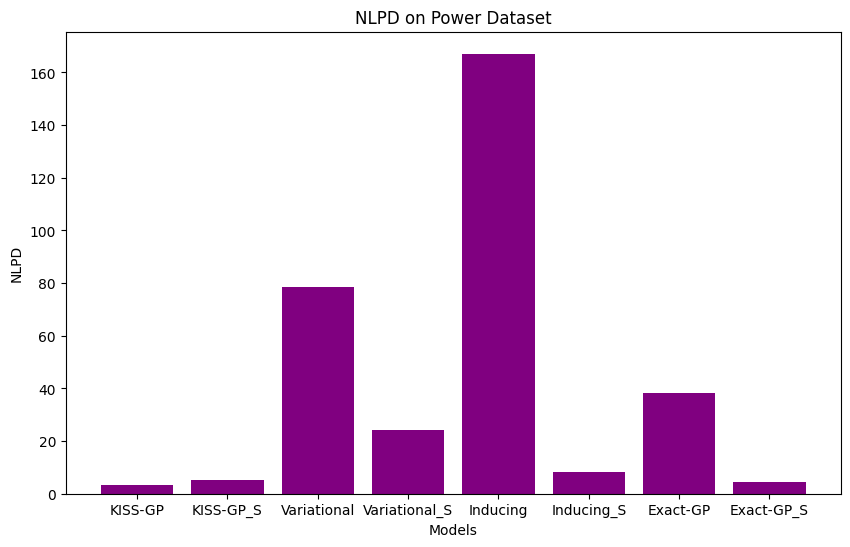

In [28]:
# Standardized or not?
# NLPD
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
NLPD_compare = [NLPD_KISSGP_power, NLPD_KISSGP_power_standardized,
                NLPD_variational_power, NLPD_variational_power_standardized,
                NLPD_inducing_power, NLPD_inducing_power_standardized,
                NLPD_exact_power, NLPD_exact_power_standardized]
plot_bar(models_compare, NLPD_compare, "NLPD on Power Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

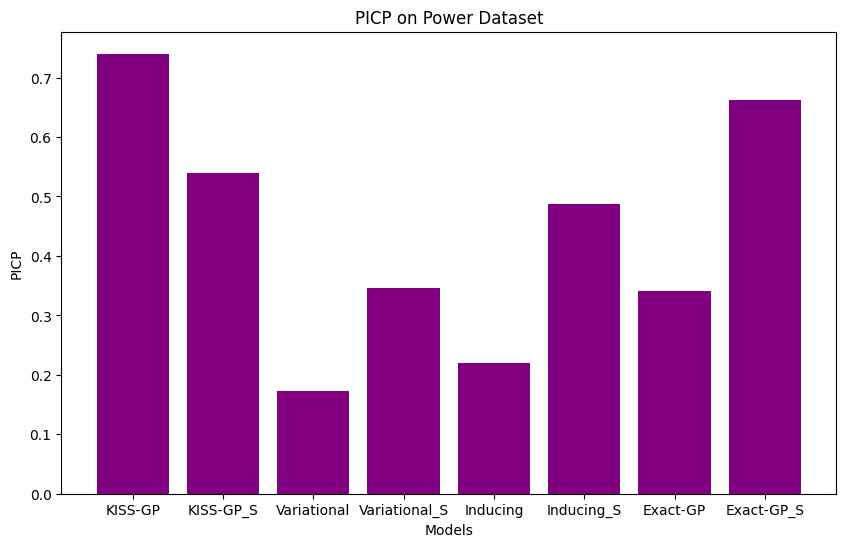

In [29]:
# Standardized or not?
# PICP
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
PICP_compare = [PICP_KISSGP_power, PICP_KISSGP_power_standardized,
                PICP_variational_power, PICP_variational_power_standardized,
                PICP_inducing_power, PICP_inducing_power_standardized,
                PICP_exact_power, PICP_exact_power_standardized]
plot_bar(models_compare, PICP_compare, "PICP on Power Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

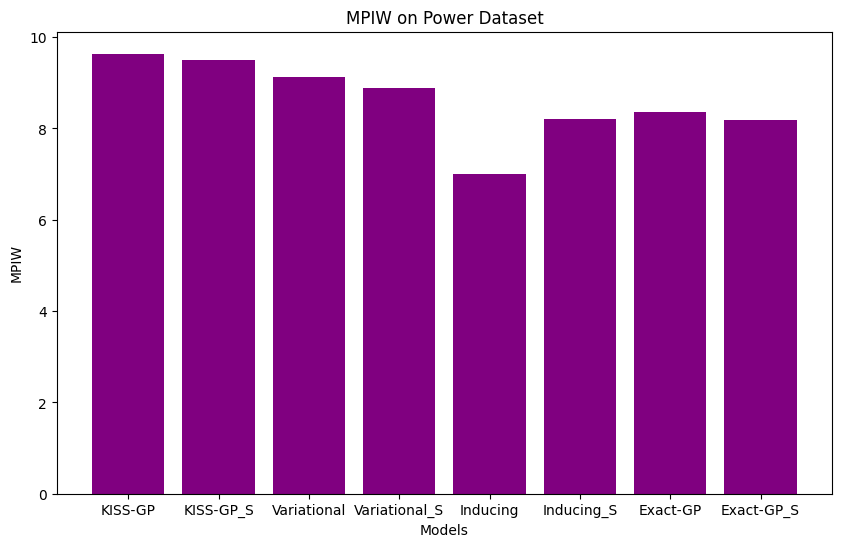

In [30]:
# Standardized or not?
# MPIW
models_compare = ["KISS-GP", "KISS-GP_S", "Variational", "Variational_S",  "Inducing", "Inducing_S", "Exact-GP", "Exact-GP_S"]
MPIW_compare = [MPIW_KISSGP_power, MPIW_KISSGP_power_standardized,
                MPIW_variational_power, MPIW_variational_power_standardized,
                MPIW_inducing_power, MPIW_inducing_power_standardized,
                MPIW_exact_power, MPIW_exact_power_standardized]
plot_bar(models_compare, MPIW_compare, "MPIW on Power Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

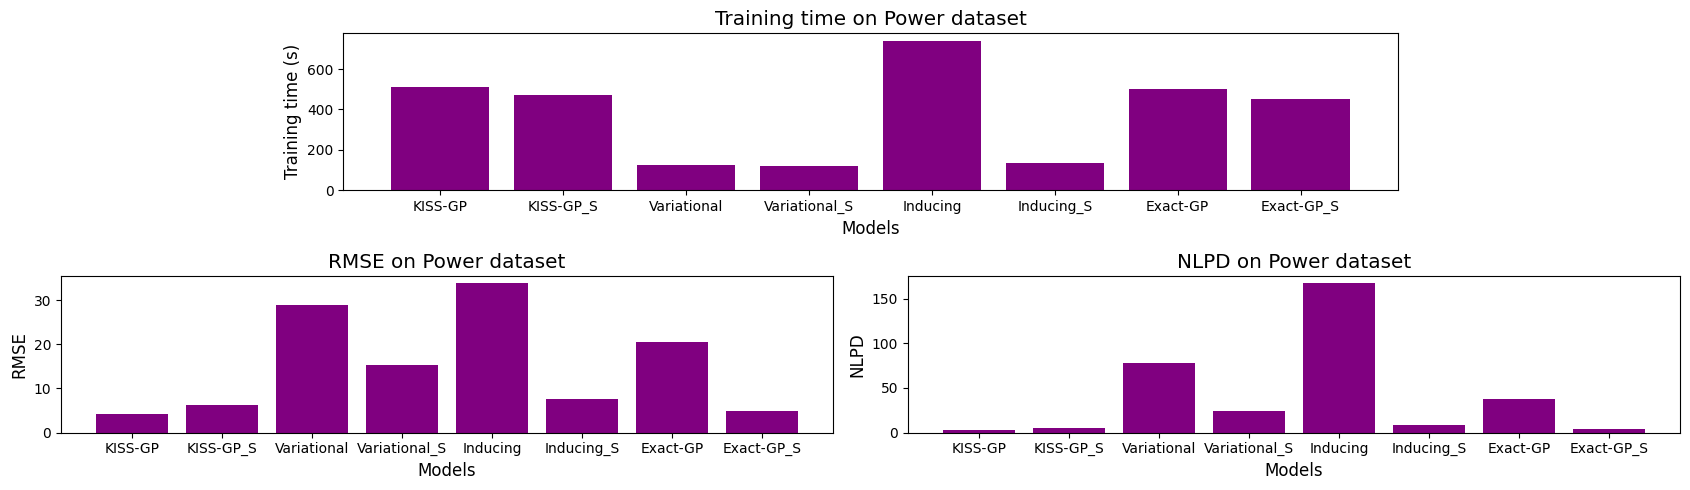

In [31]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 1:5])
ax2 = fig.add_subplot(gs[1, 0:3])
ax3 = fig.add_subplot(gs[1, 3:6])


axes = [ax1, ax2, ax3]  # List of axes
data = [time_compare, RMSE_compare, NLPD_compare]
titles = ["Training time on Power dataset", "RMSE on Power dataset", "NLPD on Power dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

ax1.set_ylabel("Training time (s)")
plt.tight_layout()
#plt.savefig("metrics_power_compare1.pdf")
plt.show()

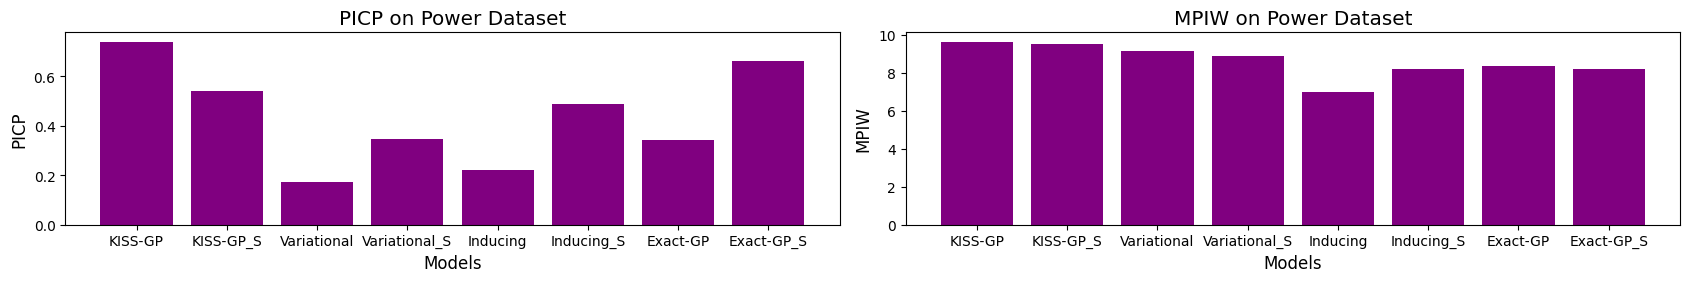

In [32]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:6])


axes = [ax1, ax2]  # List of axes
data = [PICP_compare, MPIW_compare]
titles = ["PICP on Power Dataset", "MPIW on Power Dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models_compare, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
#plt.savefig("metrics_power_compare2.pdf")
plt.show()